# Import

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch, torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset

# Используемые функции

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
PATH_MODELS = "/content/drive/MyDrive/test/models"      # папка, куда будудут сохранены модели
PATH_DATA = "./mnist"                                   # папка, куда будет загружен датасет mnist

In [6]:
def visualize_images(list_images, max_images = 10):
    
    count_images = min([len(list_images), max_images])
    
    fig, axs = plt.subplots(1, count_images)
    fig.set_figheight(3)
    fig.set_figwidth(15)
    for i in range(count_images):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(list_images[i])

    plt.show()

### Функции для автоэнкодера

In [7]:
## функция вычисления loss на валидационном датасете автоэнкодера
def validate_autoecnoder(model, device, val_dataloader):
    
    val_losses = 0
    count_steps = 0
    model.eval()
    
    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            decoded_state, loss = model(images)
            val_losses+=loss.item()
            count_steps+=1
                        
    return val_losses/count_steps

In [8]:
## функция обучения автоэнкодера
def train_autoencoder(ae_model, device, lr, num_epochs, train_dataloader, val_dataloader=None, print_losses=True):
    
    ROWS_IN_LOG = 32 ## количество шагов для замера train loss и вывода результата

    train_losses, val_losses, train_steps, val_steps = [], [], [], []
    global_step = 0  

    optimizer = torch.optim.Adam(ae_model.parameters(), lr = lr)

    ae_model.train()
    for epoch in range(num_epochs):

        if print_losses:print(f"epoch number = {epoch}")
        loss_rep= 0
        num_rep = 0

        for step, batch in enumerate(train_dataloader):

            global_step+=1

            optimizer.zero_grad()

            images, labels = batch[0].to(device), batch[1].to(device)
            decoded_state, loss = ae_model(images)

            loss_rep = loss_rep + loss.item()
            num_rep  = num_rep + 1

            loss.backward()
            optimizer.step()


            if global_step % ROWS_IN_LOG == 0: 
                if print_losses: print(f"train loss: {loss_rep/num_rep}, global step = {global_step}, num_rep= {num_rep}")
                train_losses.append(loss_rep/num_rep)
                train_steps.append(global_step)
                loss_rep = 0
                num_rep=0


        if val_dataloader is not None:
            val_loss = validate_autoecnoder(ae_model, device, val_dataloader)
            val_losses.append(val_loss)
            val_steps.append(global_step)
            if print_losses:print(f"val loss: {val_loss}, global step = {global_step}, num_rep= {epoch}")

    if print_losses:print(f"training is finished")
    
    if val_dataloader is not None:
        return train_losses, train_steps, val_losses, val_steps
    else:
        return train_losses, train_steps, None, None

    

### Функции для классификатора

In [9]:
## функция валидации модели классификации
def validate_classificator_loop(classificator, device, val_dataloader):
    
    val_losses = 0
    count_samples = 0
    classificator.eval()
    
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            logits, loss_value = classificator(images, labels)
            val_losses+=loss_value.item()
            count_samples+=1
            
            val_labels.extend(list(labels.cpu().numpy()))
            val_preds.extend(list(np.argmax(logits.cpu().detach().numpy(), axis=-1)))
                        
    return val_losses/count_samples, val_labels, val_preds

In [10]:
# функция обучения модели классификации
def train_class_model(classificator, device, lr, num_epochs, train_dataloader, val_dataloader=None, print_losses=True):

    ROWS_IN_LOG = 32

    loss_rep= 0
    num_rep = 0
    train_class_losses, val_class_losses = [], []
    train_class_f1, val_class_f1 = [], []
    train_class_steps, val_class_steps = [], []
    val_labels, val_preds = [], []
    global_step = 0
    
    optimizer = torch.optim.Adam(classificator.parameters(), lr=lr)
    classificator.train()
    for epoch in range(num_epochs):

        labels_of_batch = []
        preds_of_batch = []

        if print_losses: print(f"epoch number = {epoch}")

        for step, batch in enumerate(train_dataloader):

            global_step+=1

            optimizer.zero_grad()

            images, labels = batch[0].to(device), batch[1].to(device)
            logits, loss_value = classificator(images, labels)

            labels_of_batch.extend(list(labels.cpu().numpy()))
            preds_of_batch.extend(list(np.argmax(logits.cpu().detach().numpy(), axis=-1)))

            loss_rep = loss_rep + loss_value.item()
            num_rep  = num_rep + 1

            loss_value.backward()
            optimizer.step()

            if global_step % ROWS_IN_LOG == 0: 
                train_class_losses.append(loss_rep/num_rep)
                train_class_steps.append(global_step)

                train_class_f1.append(f1_score(y_true=labels_of_batch, y_pred = preds_of_batch, average = 'macro'))

                labels_of_batch = []
                preds_of_batch = []
                loss_rep = 0
                num_rep=0
                
        if val_dataloader is not None:
            val_loss, val_labels, val_preds = validate_classificator_loop(classificator, device, val_dataloader)
            val_class_losses.append(val_loss)
            val_class_f1.append(f1_score(y_true=val_labels, y_pred = val_preds, average = 'macro'))
            val_class_steps.append(global_step)
            
            if print_losses: print(f"val loss: {val_loss}, global step = {global_step}, num_rep= {epoch}")

    if print_losses: print(f"training is finished")
    
    train_info = {"train_class_losses":train_class_losses, "train_class_steps":train_class_steps}
    
    if val_dataloader is not None:
        train_info.update({"val_class_losses": val_class_losses, 
                           "val_class_steps": val_class_steps, 
                           "val_labels": val_labels, 
                           "val_preds": val_preds})
        
    return train_info


# Вводная часть - подготовка/анализ данных

In [12]:
# загружаем датасет MNIST
mnist_dataset = datasets.MNIST(PATH_DATA, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [16]:
# определим размеры изображений, количество классов - цифр

width_image, height_image  = mnist_dataset[0][0].shape[1], mnist_dataset[0][0].shape[2]
print(f"width_image = {width_image}, height_image = {height_image}")

OUT_SIZE = len(mnist_dataset.classes) # параметр - количество классов
print(f"OUT_SIZE = {OUT_SIZE}")

width_image = 28, height_image = 28
OUT_SIZE = 10


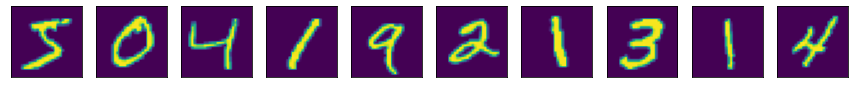

In [17]:
# визуализируем несколько первых цифр
visualize_images(list_images = [mnist_dataset[i][0].reshape(width_image, height_image) for i in range(10)])

In [18]:
## распределение классов

In [19]:
mnist_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

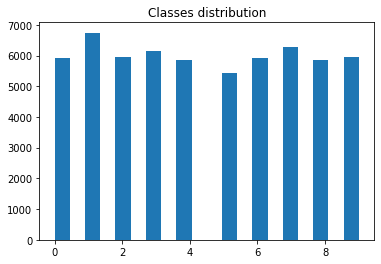

In [20]:
# распределение классов
plt.hist(mnist_dataset.targets, bins=20)
plt.title("Classes distribution")
plt.show()

In [17]:
# Вывод: датасет сбалансирован, каждый класс содержит примерно одинаковое количество сэмплов (~6000)

In [18]:
# анализ входных значений

In [26]:
# как распределены входные данные
print(f"Max X = {mnist_dataset.data.max().item()}, Min X = {mnist_dataset.data.min().item()}")

Max X = 255, Min X = 0


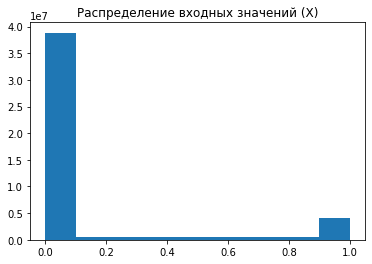

In [41]:
# распределение X
plt.hist((mnist_dataset.data / 255).reshape((-1)))
plt.title("Распределение входных значений (X)")
plt.show()

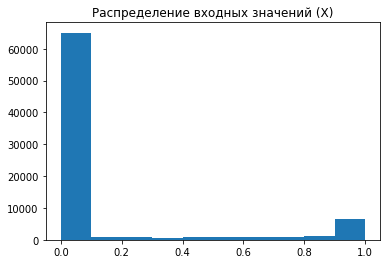

In [42]:
first_items = torch.cat([m[0] for m in mnist_dataset][:100])
plt.hist(first_items.reshape((-1)).numpy())
plt.title("Распределение входных значений (X)")
plt.show()

In [43]:
# в датесете mnist_dataset значения уже нормализованы в [0,1], дополнительная нормализация не требуется 

In [44]:
## У нас 2 задачи - 1) обучение автоэнкодера 2) обучение классификатора на латентном состоянии энкодера

## поделим множество данных (mnist_dataset) на:

#     1) подмножество данных для обучения и оценки качества автоэнкодера, 
#     2) подмножество данных для обучения и оценки качества классификатора 

In [45]:
portion_class_data = 0.5
ae_indexes, class_indexes ,_ , _ = train_test_split(range(len(mnist_dataset)), mnist_dataset.targets, test_size = portion_class_data, random_state = 2)
ae_data, class_data = Subset(mnist_dataset, ae_indexes), Subset(mnist_dataset, class_indexes)

In [46]:
# формируем train/val для автоэнкодера

In [47]:
test_size = 0.3
ae_targets = [mnist_dataset[i][1] for i in ae_data.indices]

train_ae_indexes, val_ae_indexes,_ , _ = train_test_split(ae_data.indices, ae_targets, test_size = test_size, random_state = 2)
train_ae_data, val_ae_data = Subset(mnist_dataset, train_ae_indexes), Subset(mnist_dataset, val_ae_indexes)
train_ae_dataloader = DataLoader(train_ae_data, batch_size=128, shuffle=True)
val_ae_dataloader = DataLoader(val_ae_data, batch_size=256, shuffle=False)

In [48]:
# формируем train/val для классификатора

In [49]:
test_size = 0.3
class_targets = [mnist_dataset[i][1] for i in class_data.indices]
train_class_indexes, val_class_indexes, _, _ = train_test_split(class_data.indices, class_targets, test_size = test_size, random_state = 2)
train_class_data, val_class_data = Subset(mnist_dataset, train_class_indexes), Subset(mnist_dataset, val_class_indexes)
train_class_dataloader = DataLoader(train_class_data, batch_size=128, shuffle=True)
val_class_dataloader = DataLoader(val_class_data, batch_size=256, shuffle=False)

In [50]:
for val_batch in val_ae_dataloader: break # тестовый батч

# Step2. Simple autoencoder class

In [52]:
# простой автоэнкодер на базе полносвязных слоев

## энкодер
class Encoder(torch.nn.Module):
    
    def __init__(self, input_size, encoder_size):
        super().__init__()
       
        self.encoder_size = encoder_size
        
        self.linear1 = torch.nn.Linear(input_size, input_size // 2)
        self.linear2 = torch.nn.Linear(input_size // 2, input_size // 4)
        self.linear3 = torch.nn.Linear(input_size // 4, encoder_size)

    def load_and_freeze(self, path, device):
        self.load_state_dict(torch.load(path, map_location=device))
        for param in self.parameters(): param.requires_grad = False
        
    def forward(self, image):
        
        encoded_image = torch.nn.Flatten()(image)
        
        encoded_image = self.linear1(encoded_image)
        encoded_image = torch.nn.ReLU()(encoded_image)
        encoded_image = self.linear2(encoded_image)
        encoded_image = torch.nn.ReLU()(encoded_image)
        encoded_image = self.linear3(encoded_image)
        encoder_result = torch.nn.ReLU()(encoded_image)

        return encoder_result
    
## декодер    
class Decoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        super().__init__()
        
        
        self.encoder_size = encoder_size
        self.width = width
        self.height = height
        
        input_size = height*width
        
        self.linear1 = torch.nn.Linear(encoder_size, input_size // 4)
        self.linear2 = torch.nn.Linear(input_size // 4, input_size // 2)
        self.linear3 = torch.nn.Linear(input_size // 2, input_size)
        
    def forward(self, encoder_state):
        
        decoded_image = self.linear1(encoder_state)
        decoded_image = torch.nn.ReLU()(decoded_image)
        decoded_image = self.linear2(decoded_image)
        decoded_image = torch.nn.ReLU()(decoded_image)
        decoded_image = self.linear3(decoded_image)
        decoded_image = torch.nn.Sigmoid()(decoded_image)
        
        return decoded_image

## автэнкодер
class SimpleAutoEncoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        
        super().__init__()
        
        self.width = width
        self.height = height
        
        self.encoder = Encoder(input_size = width*height, encoder_size = encoder_size)
        self.decoder = Decoder(encoder_size = encoder_size, width = width, height = height)
        
    def save_model(self, path):
        torch.save(self.state_dict(), f"{path}/simple_autoencoder.bin")
        torch.save(self.encoder.state_dict(), f"{path}/simple_encoder.bin")
        
    def forward(self, original_image):
        
        encoded_state = self.encoder(original_image)
        decoded_image = self.decoder(encoded_state)

        original_image = torch.nn.Flatten()(original_image)
        loss = torch.nn.BCELoss(reduction = 'mean')
        loss_value = loss(decoded_image, original_image)

        return decoded_image.view((-1, self.width, self.height)), loss_value

        

In [54]:
## тестируем forward encoder, decoder, model 
# test_encoder = Encoder(input_size = width_image*height_image, encoder_size = 98)
# encoded_value = test_encoder(val_batch[0])
# print(encoded_value.shape)

# test_decoder = Decoder(encoder_size = 98, width = width_image, height =height_image)
# decoded_image = test_decoder(encoder_state = encoded_value)
# print(decoded_image.shape)

# ae_model = SimpleAutoEncoder(encoder_size = 98, width = width_image, height =height_image)
# decoded_image, loss_value = ae_model(val_batch[0])
# print(decoded_image.shape, loss_value)

# Step 3. Train autoencoder model

In [55]:
## на этапе проектирования модели размер внутреннего состояния автоэнкодера ENCODER_SIZE можно выбрать, исходя из следующих соображений:
## ENCODER_SIZE должен быть меньше, чем размерность входных данных (28*28 = 784)
## ENCODER_SIZE должен быть меньше, чем разменость внутрених полносвязных слоев энкодера (784 // 4 = 196)

# выберем:
ENCODER_SIZE = 49

In [56]:
# создаем экземпляр модели, обучаем
ae_model = SimpleAutoEncoder(encoder_size = ENCODER_SIZE, width = width_image, height = height_image)

if "cuda" in device.type: ae_model.cuda()
train_losses, train_steps, val_losses, val_steps =train_autoencoder(ae_model = ae_model,
                                                                    device = device, 
                                                                    lr=1e-3, 
                                                                    num_epochs=50, 
                                                                    train_dataloader = train_ae_dataloader, 
                                                                    val_dataloader=val_ae_dataloader, 
                                                                    print_losses=False)

In [57]:
ae_model.save_model(PATH_MODELS) # сохраним модель

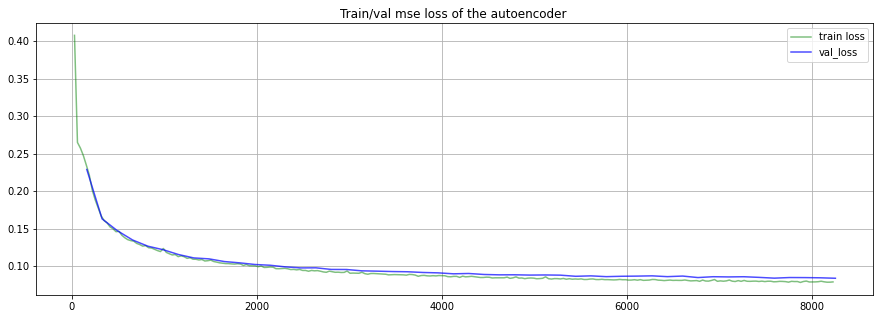

In [58]:
plt.figure(figsize = (15,5))
plt.plot(train_steps, train_losses, alpha=0.5, color = "green")
plt.plot(val_steps, val_losses, alpha=0.7, color = "blue")
plt.grid()
plt.legend(["train loss", "val_loss"])
plt.title("Train/val mse loss of the autoencoder ")
plt.show()

In [59]:
val_best_index = np.argmin(val_losses)
val_best_loss = np.min(val_losses)

print(f"the best mse VAL   loss = {val_best_loss}, global step = {val_steps[val_best_index]}")
print(f"the CURRENT mse VAL loss = {val_losses[-1]}")
print()

train_best_index = np.argmin(train_losses)
train_best_loss = np.min(train_losses)

print(f"the BEST mse TRAIN loss = {train_best_loss}, global step = {train_steps[train_best_index]}")
print(f"the CURRENT mse TRAIN loss = {train_losses[-1]}")

the best mse VAL   loss = 0.08392035174700949, global step = 8250
the CURRENT mse VAL loss = 0.08392035174700949

the BEST mse TRAIN loss = 0.07834262866526842, global step = 7872
the CURRENT mse TRAIN loss = 0.07906374149024487


In [ ]:
# визуализируем как автоэнкодер смог "восстановить" изображения

Original images:


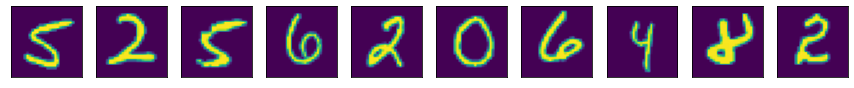

Decoded images:


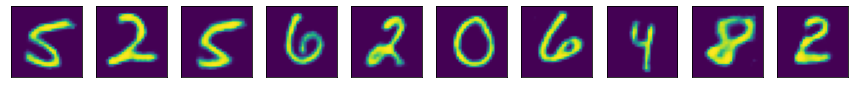

In [60]:
print("Original images:")
list_orig_images = [image[0].reshape(width_image, height_image) for i, image in enumerate(val_batch[0]) if i<20]
visualize_images(list_images=list_orig_images)

print("Decoded images:")
ae_model.cpu()
list_decoded_images = [image.detach().numpy() for i, image in enumerate(ae_model(val_batch[0])[0]) if i<20]
visualize_images(list_images=list_decoded_images)



In [64]:
# проверим как автоэнкодер восстанавливает изображения на батче с худшим лоссом
index_worst_batch = 0
max_val_loss = -1e6
for i, val_batch in enumerate(val_ae_dataloader):
  _, val_loss = ae_model(val_batch[0])
  if max_val_loss < val_loss:
    max_val_loss = val_loss
    index_worst_batch= i

for i, worst_val_batch in enumerate(val_ae_dataloader):
  if i == index_worst_batch: break 

Original images (worst_val_batch):


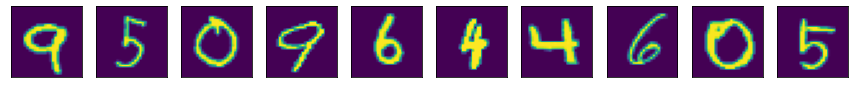

Decoded images (worst_val_batch):


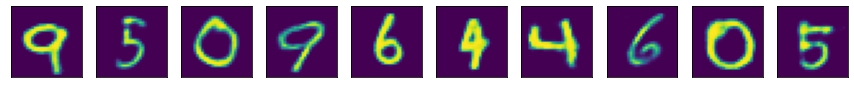

In [65]:
print("Original images (worst_val_batch):")
list_orig_images = [image[0].reshape(width_image, height_image) for i, image in enumerate(worst_val_batch[0]) if i<20]
visualize_images(list_images=list_orig_images)

print("Decoded images (worst_val_batch):")
ae_model.cpu()
list_decoded_images = [image.detach().numpy() for i, image in enumerate(ae_model(worst_val_batch[0])[0]) if i<20]
visualize_images(list_images=list_decoded_images)


In [ ]:
# по данным примерам можно сделать вывод, что автоэнкодер научился "восстанавливать" изображение по латентному состоянию энкодера

# Step 4. Classification model

In [66]:
# Модель классификации

In [67]:
class SimpleClassificator(torch.nn.Module):
    
    def __init__(self, encoder, out_size):

        super().__init__()
        self.encoder = encoder
        encoder_size = encoder.encoder_size
        
        self.dropout1 = torch.nn.Dropout(0.1)
        self.linear1 = torch.nn.Linear(encoder_size, encoder_size // 2)
        
        self.dropout2 = torch.nn.Dropout(0.1)
        self.linear2 = torch.nn.Linear(encoder_size//2, out_size)
        
    def save_model(self, path):
        torch.save(self.state_dict(), path)
  
    def forward(self, original_images, labels = None):
        
        encoded_state = self.encoder(original_images)

        if isinstance(encoded_state, tuple): encoded_state = encoded_state[0]
        
        hidden_state = self.dropout1(encoded_state)
        hidden_state = self.linear1(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        
        hidden_state = self.dropout2(hidden_state)
        logits = self.linear2(hidden_state)
        softmax_logits = torch.nn.Softmax(dim=-1)(logits)
        
        if labels is not None:
            loss = torch.nn.CrossEntropyLoss(reduction ='mean')
            loss_value = loss(logits, labels)
            return logits,  loss_value
        else:
            return logits


# Step 5. Train classification model

In [69]:
# создаем ранее обученый энкодер, замораживам веса
encoder = Encoder(input_size = width_image*height_image, encoder_size=ENCODER_SIZE)
encoder.load_and_freeze(f"{PATH_MODELS}/simple_encoder.bin", device = device)


# создаем классификатор, запускаем обучение
class_model = SimpleClassificator(encoder = encoder, out_size=OUT_SIZE)
if "cuda" in device.type: class_model.cuda()

train_info =  train_class_model(classificator = class_model,
                                num_epochs=50, 
                                device = device,
                                lr = 1e-4,
                                train_dataloader = train_class_dataloader, 
                                val_dataloader = val_class_dataloader, 
                                print_losses=False)

In [70]:
class_model.save_model(f"{PATH_MODELS}/simple_classificator.bin")

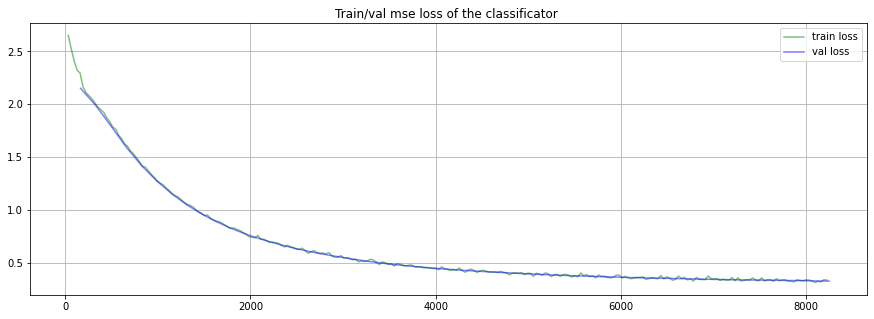

In [71]:
plt.figure(figsize = (15,5))
plt.plot(train_info["train_class_steps"], train_info["train_class_losses"], alpha=0.5, color = "green")
plt.plot(train_info["val_class_steps"], train_info["val_class_losses"], alpha=0.5, color = "blue")
plt.grid()
plt.legend(["train loss", "val loss"])
plt.title("Train/val mse loss of the classificator ")
plt.show()

In [73]:
# отчет точность классификации
print(classification_report(y_pred= train_info["val_preds"], y_true = train_info["val_labels"]))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       894
           1       0.93      0.97      0.95       973
           2       0.88      0.86      0.87       881
           3       0.91      0.87      0.89       920
           4       0.92      0.90      0.91       920
           5       0.88      0.84      0.86       847
           6       0.93      0.94      0.93       950
           7       0.92      0.92      0.92       894
           8       0.87      0.88      0.87       835
           9       0.85      0.88      0.87       886

    accuracy                           0.90      9000
   macro avg       0.90      0.90      0.90      9000
weighted avg       0.90      0.90      0.90      9000



In [74]:
# матрица ошибок
conf_matrix = confusion_matrix(y_pred= train_info["val_preds"], y_true = train_info["val_labels"])
pd.DataFrame(conf_matrix)

,0,1,2,3,4,5,6,7,8,9
0,851,0,7,2,1,11,9,2,9,2
1,0,939,6,2,3,4,3,1,13,2
2,5,17,757,9,15,4,14,17,29,14
3,16,7,28,798,0,34,3,4,21,9
4,2,3,12,1,824,1,10,7,4,56
5,21,10,17,36,6,712,18,4,20,3
6,8,8,6,0,11,19,889,2,6,1
7,11,2,9,1,9,2,0,825,3,32
8,4,20,20,13,2,19,10,2,731,14
9,5,7,3,18,24,6,0,36,7,780


In [ ]:
# в confusion_matrix вне "диагонали" расположены ошибки (truth значения - строки, pred - значения столбцы)
# рассмотрм наиболее частотные ошибки:

In [75]:
def decode(x):
    return ae_model(x)[0].detach().numpy().reshape(width_image,height_image)
    
def visualize_conf_pairs(truth_label, pred_label, dataset, truth, pred):
    print(f"Original images ({truth_label} - > {pred_label}):")
    bad_list_images = [dataset[i][0].reshape(width_image,height_image) for i, (t, p) in enumerate(zip(truth, pred)) if t==truth_label and p==pred_label]
    visualize_images(list_images=bad_list_images)

    print(f"Decoded images ({truth_label} - > {pred_label}):")
    bad_list_decoded_images = [decode(dataset[i][0])  for i, (t, p) in enumerate(zip(truth, pred)) if t==truth_label and p==pred_label]
    visualize_images(list_images=bad_list_decoded_images)

In [76]:
# 1) truth = 3, pred = 5 (данные цифры схожи по написанию)

Original images (3 - > 5):


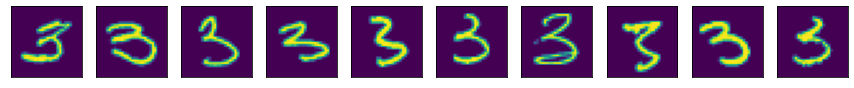

Decoded images (3 - > 5):


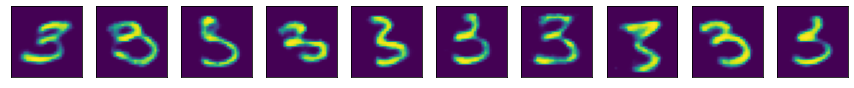

In [77]:
visualize_conf_pairs(truth_label=3, pred_label=5, dataset=val_class_data, truth = train_info["val_labels"], pred=train_info["val_preds"])

In [78]:
# 2) truth = 5, pred = 0 

Original images (5 - > 0):


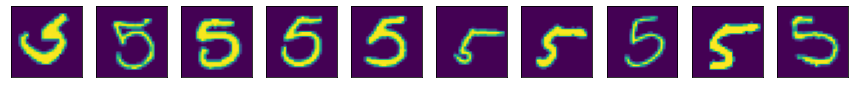

Decoded images (5 - > 0):


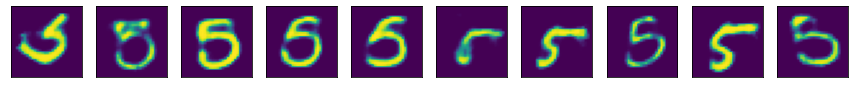

In [79]:
visualize_conf_pairs(truth_label=5, pred_label=0, dataset=val_class_data, truth = train_info["val_labels"], pred=train_info["val_preds"])

In [80]:
# 3) truth = 9, pred = 4

Original images (9 - > 4):


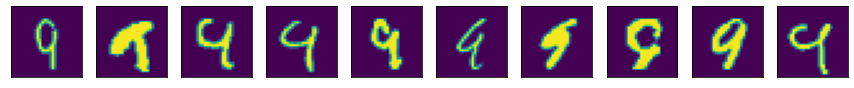

Decoded images (9 - > 4):


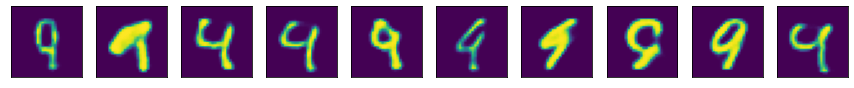

In [81]:
visualize_conf_pairs(truth_label=9, pred_label=4, dataset=val_class_data, truth = train_info["val_labels"], pred=train_info["val_preds"])

In [ ]:
# Выводы:
# 1) модель не верно классифицировала "сложные" случаи, где написание цифр не разборчивое
# 2) модель ошибается на схожих по написанию цифрах (3,5), (3, 8)

# Step 6. Идеи по повышению точности классификаации

## Step 6.1 CNN Autoencoder

In [82]:
# реализация энекодера и декодера содержат только полносвязанные слои
# использование CNN позволит автоэнкодеру выявлять признаки геометрические примитивы (углы, штрихи etc.)

### CNN Autoencoder model

In [83]:
class CNNEncoder(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn1 = torch.nn.Conv2d(in_channels = 1, 
                                    out_channels = 512, 
                                    kernel_size = (5,5),
                                    padding = 'same',
                                    padding_mode = 'zeros')
        
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size = (2,2), 
                                           stride = (2,2))
        
        self.cnn2 = torch.nn.Conv2d(in_channels = 512, 
                                    out_channels = 256, 
                                    kernel_size = (5,5),
                                    padding = 'same',
                                    padding_mode = 'zeros')
        
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size = (2,2), 
                                           stride = (2,2))

        self.cnn3 = torch.nn.Conv2d(in_channels = 256, 
                                    out_channels = 1, 
                                    kernel_size = (7,7),
                                    padding = 'same',
                                    padding_mode = 'zeros')
        
        self.encoder_size = 49
        
    def load_and_freeze(self, path, device):
        self.load_state_dict(torch.load(path, map_location=device))
        for param in self.parameters(): param.requires_grad = False
        
        

        
    def forward(self, image, print_shapes = False):
        
        if print_shapes: print(f"image shape = {image.shape}")  
        
        encoded_image = self.cnn1(image)  
        if print_shapes: print(f"cnn1 out shape = {encoded_image.shape}")
            
        encoded_image = torch.nn.ReLU()(encoded_image)  
        
        encoded_image = self.maxpool1(encoded_image)  
        if print_shapes: print(f"maxpool1 out shape = {encoded_image.shape}")
            
            
        encoded_image = self.cnn2(encoded_image)
        if print_shapes: print(f"cnn2 out shape = {encoded_image.shape}")
       
        encoded_image = torch.nn.ReLU()(encoded_image) 

        encoded_image = self.maxpool2(encoded_image)  
        if print_shapes: print(f"maxpool1 out shape = {encoded_image.shape}")

        encoded_image = self.cnn3(encoded_image)
        if print_shapes: print(f"cnn2 out shape = {encoded_image.shape}")
       
        
        encoded_image = torch.nn.Flatten()(encoded_image)
            
        return encoded_image  
    
    
class CNNDecoder(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
        
        self.cnn1 = torch.nn.Conv2d(in_channels = 1, 
                                    out_channels = 256, 
                                    kernel_size = (7,7), 
                                    padding = 'same')
        
        
        self.upsampler2 = torch.nn.Upsample(scale_factor = 2)
        
        self.cnn2 = torch.nn.Conv2d(in_channels = 256, 
                                    out_channels = 512, 
                                    kernel_size = (5,5),padding = 'same')
        
        self.upsampler3 = torch.nn.Upsample(scale_factor = 2)

        self.cnn3 = torch.nn.Conv2d(in_channels = 512, 
                                    out_channels = 1, 
                                    kernel_size = (5,5),padding = 'same')
        
        
   
        
    def forward(self, image, print_shapes = False):
        
        if print_shapes: print(f"image shape = {image.shape}") 
            
        
        decoded_image = self.cnn1(image)     
        if print_shapes: print(f"cnn1 out shape = {decoded_image.shape}")
            
        decoded_image = self.upsampler2(decoded_image)  
        if print_shapes: print(f"upsampler2 out shape = {decoded_image.shape}")
        decoded_image = self.cnn2(decoded_image) 
        if print_shapes: print(f"cnn2 out shape = {decoded_image.shape}")

        decoded_image = self.upsampler3(decoded_image)  
        if print_shapes: print(f"upsampler3 out shape = {decoded_image.shape}")
        decoded_image = self.cnn3(decoded_image) 
        if print_shapes: print(f"cnn2 out shape = {decoded_image.shape}")
        
        decoded_image = torch.nn.Sigmoid()(decoded_image)
        if print_shapes: print(f"cnn4 out shape = {decoded_image.shape}")
            
           
        return decoded_image

In [84]:
# test forward
# cnn_encoder = CNNEncoder()
# encoded_cnn_state = cnn_encoder(x[0], print_shapes = True)
# print(encoded_cnn_state.shape)

# cnn_decoder = CNNDecoder()
# decoded_cnn_image = cnn_decoder(encoded_cnn_state.reshape((-1, 1, 7, 7)), print_shapes = True)
# print(decoded_cnn_image.shape)

In [85]:
class CNNAutoEncoder(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.cnn_encoder = CNNEncoder()
        self.cnn_decoder = CNNDecoder()
        
    def save_model(self, path):
        
        torch.save(self.state_dict(), f"{path}/cnn_autoencoder.bin")
        torch.save(self.cnn_encoder.state_dict(), f"{path}/cnn_encoder.bin")
        
    def forward(self, original_image, print_shapes = False):
        
        if print_shapes: print(f"original_image shape = {original_image.shape}")
        
        encoded_cnn_state = self.cnn_encoder(original_image)
        if print_shapes: print(f"encoded_cnn_state shape = {encoded_cnn_state.shape}")
            
        encoded_cnn_state = encoded_cnn_state.reshape((-1, 1, 7, 7)) # flatten view to image size
        if print_shapes: print(f"reshaped encoded_cnn_state shape = {encoded_cnn_state.shape}")
        
        decoded_cnn_image = self.cnn_decoder(encoded_cnn_state)
        if print_shapes: print(f"decoded_cnn_image shape = {decoded_cnn_image.shape}")

        loss = torch.nn.BCELoss(reduction = 'mean')
        loss_value = loss(decoded_cnn_image, original_image)

        return decoded_cnn_image.view((-1, original_image.shape[2], original_image.shape[3])), loss_value

        

### CNN Autoencoder train

In [68]:
train_ae_dataloader = DataLoader(train_ae_data, batch_size=128, shuffle=True)
val_ae_dataloader = DataLoader(val_ae_data, batch_size=256, shuffle=False)

In [86]:
ae_cnn_model = CNNAutoEncoder()
if "cuda" in device.type: ae_cnn_model.cuda()

train_cnn_losses, train_cnn_steps, \
val_cnn_losses, val_cnn_steps =train_autoencoder(ae_model = ae_cnn_model,
                                                 device = device,
                                                 lr=5e-5, 
                                                 num_epochs=50, 
                                                 train_dataloader = train_ae_dataloader, 
                                                 val_dataloader=val_ae_dataloader, 
                                                 print_losses=False)

In [87]:
ae_cnn_model.save_model(PATH_MODELS)

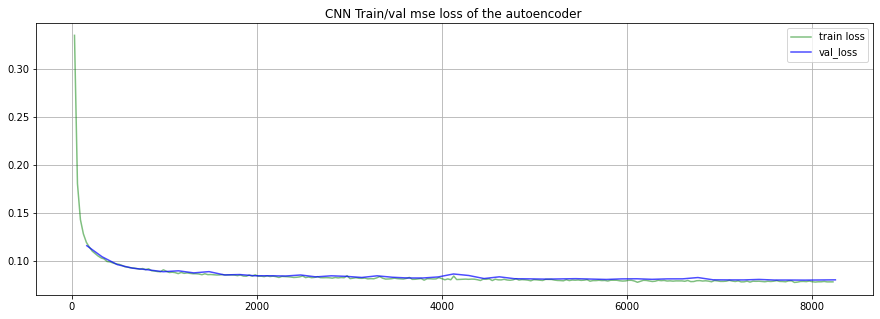

In [88]:
plt.figure(figsize = (15,5))
plt.plot(train_cnn_steps, train_cnn_losses, alpha=0.5, color = "green")
plt.plot(val_cnn_steps, val_cnn_losses, alpha=0.7, color = "blue")
plt.grid()
plt.legend(["train loss", "val_loss"])
plt.title("CNN Train/val mse loss of the autoencoder ")
plt.show()

In [89]:
val_best_index = np.argmin(val_cnn_losses)
val_best_loss = np.min(val_cnn_losses)

print(f"the best mse VAL   loss = {val_best_loss}, global step = {val_steps[val_best_index]}")
print(f"the CURRENT mse VAL loss = {val_cnn_losses[-1]}")
print()

train_best_index = np.argmin(train_cnn_losses)
train_best_loss = np.min(train_cnn_losses)

print(f"the BEST mse TRAIN loss = {train_best_loss}, global step = {train_steps[train_best_index]}")
print(f"the CURRENT mse TRAIN loss = {train_cnn_losses[-1]}")

the best mse VAL   loss = 0.0796185311757856, global step = 7920
the CURRENT mse VAL loss = 0.07991153622666995

the BEST mse TRAIN loss = 0.07719477452337742, global step = 7808
the CURRENT mse TRAIN loss = 0.07780682435259223


In [ ]:
# loss у CNN автоэнкодера уменьшился на ~ 0.004

### Train classificator

In [ ]:
# обучим классификатор, используя CNN автоэнкодер

In [90]:
cnn_encoder = CNNEncoder()
cnn_encoder.load_and_freeze(f"{PATH_MODELS}/cnn_encoder.bin", device=device)

class_cnn_model = SimpleClassificator(encoder = cnn_encoder, out_size=OUT_SIZE)
if "cuda" in device.type: class_cnn_model.cuda()

train_cnn_info =  train_class_model(classificator = class_cnn_model,
                                    num_epochs=50, 
                                    device = device,
                                    lr = 5e-4,
                                    train_dataloader = train_class_dataloader, 
                                    val_dataloader = val_class_dataloader, 
                                    print_losses=False)

In [91]:
class_cnn_model.save_model(f"{PATH_MODELS}/cnn_classificator.bin")

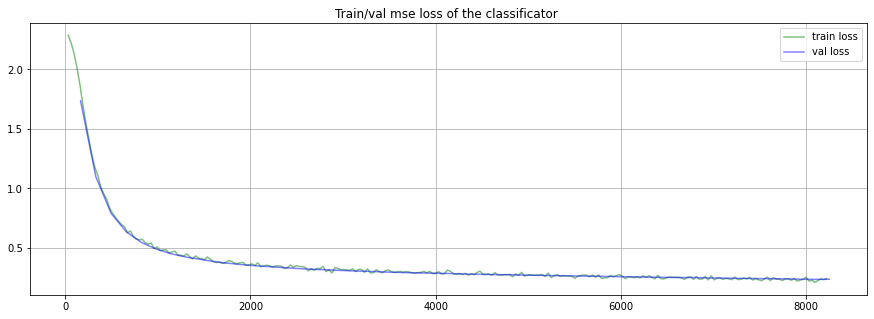

In [92]:
plt.figure(figsize = (15,5))
plt.plot(train_cnn_info["train_class_steps"], train_cnn_info["train_class_losses"], alpha=0.5, color = "green")
plt.plot(train_cnn_info["val_class_steps"], train_cnn_info["val_class_losses"], alpha=0.5, color = "blue")
plt.grid()
plt.legend(["train loss", "val loss"])
plt.title("Train/val mse loss of the classificator ")
plt.show()

In [93]:
# отчет точность классификации
print(classification_report(y_pred= train_cnn_info["val_preds"], y_true = train_cnn_info["val_labels"]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       894
           1       0.97      0.97      0.97       973
           2       0.93      0.91      0.92       881
           3       0.90      0.91      0.90       920
           4       0.93      0.97      0.95       920
           5       0.90      0.89      0.89       847
           6       0.97      0.94      0.96       950
           7       0.93      0.95      0.94       894
           8       0.88      0.89      0.88       835
           9       0.93      0.90      0.92       886

    accuracy                           0.93      9000
   macro avg       0.93      0.93      0.93      9000
weighted avg       0.93      0.93      0.93      9000



In [94]:
# Вывод: точность увеличилась на 4 пункта, использование сверточного автоэнкодера повышает точность модели классификации

## Step 6.2. Анализ кода автоэнкодера 

### Код на множестве данных для обучения классификатора

In [95]:
# проанализируем значения элементов латентного сстояния энкодера

In [96]:
encoder = Encoder(input_size = width_image*height_image, encoder_size=ENCODER_SIZE)
encoder.load_and_freeze(f"{PATH_MODELS}/simple_encoder.bin", device = device)
if "cuda" in device.type: encoder.cuda()


In [117]:
code_of_train_class = None
encoder.eval()
for train_batch in tqdm(train_class_dataloader):
  images = train_batch[0].to(device)
  with torch.no_grad():
    
    code = encoder(images)
    if code_of_train_class is None:
      code_of_train_class = code.cpu().detach().numpy()
    else:
      code_of_train_class = np.vstack([code_of_train_class, code.cpu().detach().numpy()])

100%|██████████| 165/165 [00:02<00:00, 80.71it/s]


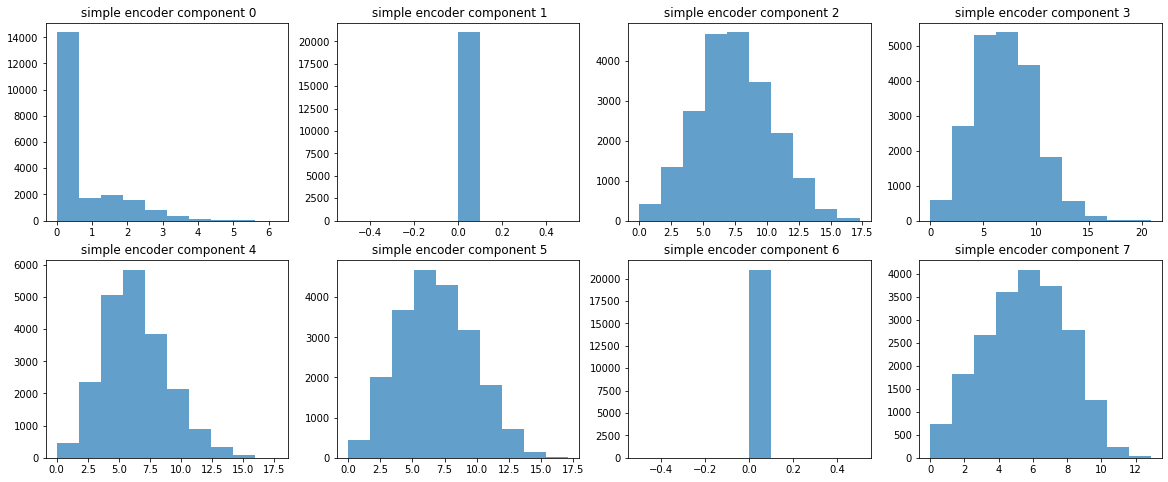

In [118]:
fig, axs = plt.subplots(2, 4)
fig.set_figheight(8)
fig.set_figwidth(20)
for i in range(8):
  row = i // 4
  col = i % 4
  axs[row,col].hist(code_of_train_class[:,i],  alpha = 0.7)
  axs[row,col].set_title(f" simple encoder component {i}")
plt.show()

In [102]:
# В распределениях элементов латентного состояния имеются элементы, которые принимают только нулевые значения. 
# Оценим их количество.

means, stds = [], []
for i in range(ENCODER_SIZE):
  means.append(np.mean(code_of_train_class[:,i]))
  stds.append(np.std(code_of_train_class[:,i]))
mean_std_data = pd.DataFrame(data = {"mean": means, "std":stds})
NOT_USED_SIZE = mean_std_data[mean_std_data["std"] == 0].shape[0]
print(f"В латентном состоянии автоэнкодера не используется {NOT_USED_SIZE} элементов")

В латентном состоянии автоэнкодера не используется 17 элементов


In [ ]:
# Вывод:
# значения внутреннего состяния не нормализованы в [0,1], матожидание не равно 0, дисперсия не равна 1
# есть компоненты, которые принимают только нулевое значение, они появляются по причине присутствия  RELU в энкодере

### Использование Tanh в автоэнкодере

In [104]:
# попробуем использовать в автоэнкодере гипербоолический тангенс вместо RELU

In [105]:
class TanhEncoder(torch.nn.Module):
    
    def __init__(self, input_size, encoder_size):
        super().__init__()
       
        self.encoder_size = encoder_size
        
        self.linear1 = torch.nn.Linear(input_size, input_size // 2)
        self.linear2 = torch.nn.Linear(input_size // 2, input_size // 4)
        self.linear3 = torch.nn.Linear(input_size // 4, encoder_size)

    def load_and_freeze(self, path, device):
        self.load_state_dict(torch.load(path, map_location=device))
        for param in self.parameters(): param.requires_grad = False
        
    def forward(self, image):
        
        encoded_image = torch.nn.Flatten()(image)
        
        encoded_image = self.linear1(encoded_image)
        encoded_image = torch.nn.Tanh()(encoded_image)
        encoded_image = self.linear2(encoded_image)
        encoded_image = torch.nn.Tanh()(encoded_image)
        encoded_image = self.linear3(encoded_image)
        encoder_result = torch.nn.Tanh()(encoded_image)

        return encoder_result
    
    
class TanhDecoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        super().__init__()
        
        
        self.encoder_size = encoder_size
        self.width = width
        self.height = height
        
        input_size = height*width
        
        self.linear1 = torch.nn.Linear(encoder_size, input_size // 4)
        self.linear2 = torch.nn.Linear(input_size // 4, input_size // 2)
        self.linear3 = torch.nn.Linear(input_size // 2, input_size)
        
    def forward(self, encoder_state):
        
        decoded_image = self.linear1(encoder_state)
        decoded_image = torch.nn.Tanh()(decoded_image)
        decoded_image = self.linear2(decoded_image)
        decoded_image = torch.nn.Tanh()(decoded_image)
        decoded_image = self.linear3(decoded_image)
        decoded_image = torch.nn.Sigmoid()(decoded_image)
        
        return decoded_image


class TanhAutoEncoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        
        super().__init__()
        
        self.width = width
        self.height = height
        
        self.encoder = TanhEncoder(input_size = width*height, encoder_size = encoder_size)
        self.decoder = TanhDecoder(encoder_size = encoder_size, width = width, height = height)
        
    def save_model(self, path):
        torch.save(self.state_dict(), f"{path}/tanh_autoencoder.bin")
        torch.save(self.encoder.state_dict(), f"{path}/tanh_encoder.bin")
        
    def forward(self, original_image):
        
        encoded_state = self.encoder(original_image)
        decoded_image = self.decoder(encoded_state)

        original_image = torch.nn.Flatten()(original_image)
        loss = torch.nn.BCELoss(reduction = 'mean')
        loss_value = loss(decoded_image, original_image)

        return decoded_image.view((-1, self.width, self.height)), loss_value

        


In [106]:
ae_tanh_model = TanhAutoEncoder(encoder_size = ENCODER_SIZE, width = width_image, height = height_image)
if "cuda" in device.type: ae_tanh_model.cuda()
train_tanh_losses, train_tanh_steps, val_tanh_losses, val_tanh_steps =train_autoencoder(ae_model = ae_tanh_model,
                                                                      device = device, 
                                                                      lr=1e-3, 
                                                                      num_epochs=50, 
                                                                      train_dataloader = train_ae_dataloader, 
                                                                      val_dataloader=val_ae_dataloader, 
                                                                      print_losses=False)

In [107]:
ae_tanh_model.save_model(PATH_MODELS)

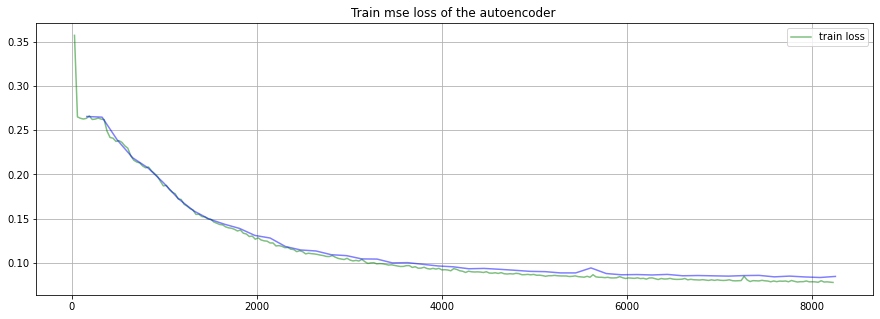

In [108]:
plt.figure(figsize = (15,5))
plt.plot(train_tanh_steps, train_tanh_losses, alpha=0.5, color = "green")
plt.plot(val_tanh_steps, val_tanh_losses, alpha=0.5, color = "blue")
plt.grid()
plt.legend(["train loss"])
plt.title("Train mse loss of the autoencoder ")
plt.show()

In [109]:
val_best_index = np.argmin(val_tanh_losses)
val_best_loss = np.min(val_tanh_losses)

print(f"the best mse VAL   loss = {val_best_loss}, global step = {val_steps[val_best_index]}")
print(f"the CURRENT mse VAL loss = {val_tanh_losses[-1]}")
print()

train_best_index = np.argmin(train_tanh_losses)
train_best_loss = np.min(train_tanh_losses)

print(f"the BEST mse TRAIN loss = {train_best_loss}, global step = {train_steps[train_best_index]}")
print(f"the CURRENT mse TRAIN loss = {train_tanh_losses[-1]}")

the best mse VAL   loss = 0.08349076617095205, global step = 8085
the CURRENT mse VAL loss = 0.08470707345339987

the BEST mse TRAIN loss = 0.07790409028530121, global step = 8224
the CURRENT mse TRAIN loss = 0.07790409028530121


In [ ]:
# лосс автоэнкодера стал больше (по сравнению с SimpleAutoencoder)

In [ ]:
# посмотрим на распределения скрытого состояния автоэнкодера

In [110]:
code_of_train_class = None
ae_tanh_model.eval()
for train_batch in tqdm(train_class_dataloader):
  images = train_batch[0].to(device)
  with torch.no_grad():
    
    code = ae_tanh_model.encoder(images)
    if code_of_train_class is None:
      code_of_train_class = code.cpu().detach().numpy()
    else:
      code_of_train_class = np.vstack([code_of_train_class, code.cpu().detach().numpy()])

100%|██████████| 165/165 [00:01<00:00, 87.70it/s]


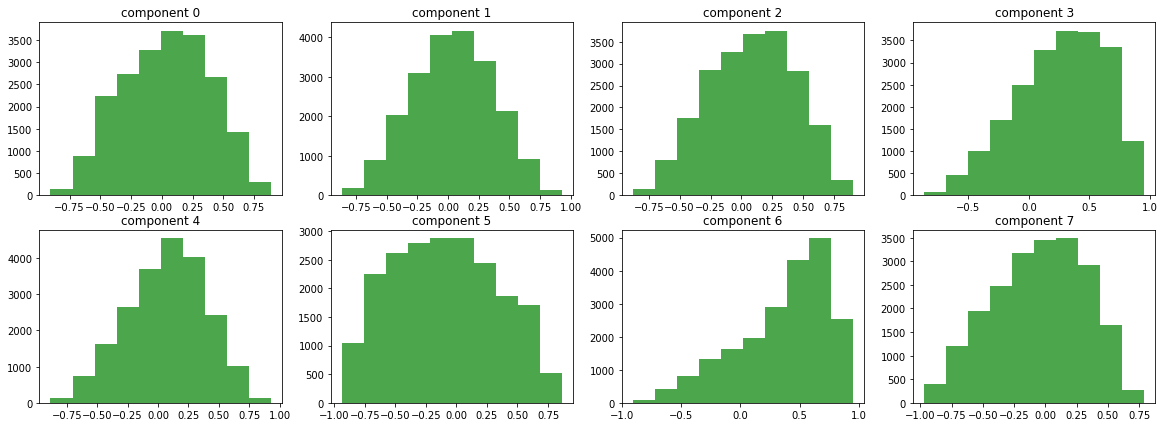

In [111]:
fig, axs = plt.subplots(2, 4)
fig.set_figheight(7)
fig.set_figwidth(20)
for i in range(8):
  row = i // 4
  col = i % 4
  axs[row,col].hist(code_of_train_class[:,i], color='green', alpha = 0.7)
  axs[row,col].set_title(f"component {i}")
plt.show()

In [112]:
means, stds = [], []
for i in range(ENCODER_SIZE):
  means.append(np.mean(code_of_train_class[:,i]))
  stds.append(np.std(code_of_train_class[:,i]))
mean_std_data = pd.DataFrame(data = {"mean": means, "std":stds})
NOT_USED_SIZE = mean_std_data[mean_std_data["std"] == 0].shape[0]
print(f"Не используется {NOT_USED_SIZE} элементов")

Не используется 0 элементов


In [ ]:
# теперь компоненты состояния автоенкодера распределены в диапазоне [-1,1],
# (кажется что) матожидание ближе к 0, отклонение все еще не равно 1

In [ ]:
# обучим классификатор 

In [114]:
tanh_encoder = TanhEncoder(encoder_size = ENCODER_SIZE, input_size = width_image*height_image)
tanh_encoder.load_and_freeze(f"{PATH_MODELS}/tanh_encoder.bin", device = device)

class_tanh_model = SimpleClassificator(encoder = cnn_encoder, out_size=OUT_SIZE)
if "cuda" in device.type: class_tanh_model.cuda()

train_tanh_info =  train_class_model(classificator = class_tanh_model,
                                    num_epochs=50, 
                                    device = device,
                                    lr = 5e-4,
                                    train_dataloader = train_class_dataloader, 
                                    val_dataloader = val_class_dataloader, 
                                    print_losses=False)


In [115]:
class_tanh_model.save_model(f"{PATH_MODELS}/tanh_classifier.bin")

In [116]:
# отчет точность классификации
print(classification_report(y_pred= train_tanh_info["val_preds"], y_true = train_tanh_info["val_labels"]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       894
           1       0.98      0.97      0.97       973
           2       0.92      0.92      0.92       881
           3       0.92      0.91      0.92       920
           4       0.94      0.96      0.95       920
           5       0.94      0.88      0.91       847
           6       0.96      0.96      0.96       950
           7       0.95      0.95      0.95       894
           8       0.85      0.91      0.88       835
           9       0.93      0.91      0.92       886

    accuracy                           0.93      9000
   macro avg       0.93      0.93      0.93      9000
weighted avg       0.93      0.93      0.93      9000



In [ ]:
# Вывод: использование Tanh в автоэнкодере повышает точность(accuracy) классификатора на 3 пункта

## Step 6.3 Вариационный автоэнкодер

In [122]:
# Вариационный автоэнкодер реализует отображение входных данный в вектор латентного состояния, 
# каждый элемент которого имеет нормальное распределение со матожиданием 0, отклонением 1

In [124]:
class VEncoder(torch.nn.Module):
    
    def __init__(self, input_size, encoder_size):
        super().__init__()
       
        self.encoder_size = encoder_size
        
        self.linear1 = torch.nn.Linear(input_size, input_size // 2)
        self.batchnorm1 = torch.nn.BatchNorm1d(num_features = input_size // 2)
        self.dropout1 = torch.nn.Dropout(0.2)

        self.linear2 = torch.nn.Linear(input_size // 2, input_size // 4)
        self.batchnorm2 = torch.nn.BatchNorm1d(num_features = input_size // 4)
        self.dropout2 = torch.nn.Dropout(0.2)

        self.mean = torch.nn.Linear(input_size // 4, encoder_size)
        self.log_var = torch.nn.Linear(input_size // 4, encoder_size)

    def load_and_freeze(self, path, device):
        self.load_state_dict(torch.load(path, map_location=device))
        for param in self.parameters(): param.requires_grad = False
        
    def forward(self, image, print_shapes = False):

        encoded_image = torch.nn.Flatten()(image)
        if print_shapes: print(f"encoded_image shape = {encoded_image.shape}")
        
        encoded_image = self.linear1(encoded_image)
        if print_shapes: print(f"val linear1 shape = {encoded_image.shape}")

        encoded_image = torch.nn.ReLU()(encoded_image)
        encoded_image = self.batchnorm1 (encoded_image)
        encoded_image = self.dropout1(encoded_image)

        encoded_image = self.linear2(encoded_image)
        if print_shapes: print(f"val linear2 shape = {encoded_image.shape}")

        encoded_image = torch.nn.ReLU()(encoded_image)
        encoded_image = self.batchnorm2(encoded_image)
        encoded_image = self.dropout2(encoded_image)

        mean_val = self.mean(encoded_image)
        if print_shapes: print(f"mean_val shape = {mean_val.shape}")

        log_var_val = self.log_var(encoded_image)
        if print_shapes: print(f"log_var_val shape = {log_var_val.shape}")

        batch_size = image.shape[0]
        if print_shapes: print(f"batch_size = {batch_size}")
        if print_shapes: print(f"self.encoder_size = {self.encoder_size}")

        current_device = self.linear1.weight.data.device ### current device to get normal_vlaues on the same device
        # normal_values = torch.normal(mean = 0.0, std =1.0, size = [batch_size, self.encoder_size]).to(current_device)
        normal_values = torch.rand_like(mean_val, device = current_device)
        if print_shapes: print(f"normal_values shape = {normal_values.shape}")
        
        
        encoder_result = normal_values*torch.exp(log_var_val*0.5) + mean_val
        if print_shapes: print(f"encoder_result shape = {encoder_result.shape}")

        return encoder_result, mean_val, log_var_val
    
    
class VDecoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        super().__init__()
        
        self.encoder_size = encoder_size
        self.width = width
        self.height = height
        
        input_size = height*width
        
        self.linear1 = torch.nn.Linear(encoder_size, input_size // 4)
        self.batchnorm1 = torch.nn.BatchNorm1d(num_features = input_size // 4)
        self.dropout1 = torch.nn.Dropout(0.2)

        self.linear2 = torch.nn.Linear(input_size // 4, input_size // 2)
        self.batchnorm2 = torch.nn.BatchNorm1d(num_features = input_size // 2)
        self.dropout2 = torch.nn.Dropout(0.2)

        self.linear3 = torch.nn.Linear(input_size // 2, input_size)
        
    def forward(self, encoder_state):
        
        decoded_image = self.linear1(encoder_state)
        decoded_image = torch.nn.ReLU()(decoded_image)
        decoded_image = self.batchnorm1(decoded_image)
        decoded_image = self.dropout1(decoded_image)

        decoded_image = self.linear2(decoded_image)
        decoded_image = torch.nn.ReLU()(decoded_image)
        decoded_image = self.batchnorm2(decoded_image)
        decoded_image = self.dropout2(decoded_image)

        decoded_image = self.linear3(decoded_image)
        decoded_image = torch.nn.Sigmoid()(decoded_image)
        
        return decoded_image


class VAutoEncoder(torch.nn.Module):
    
    def __init__(self, encoder_size, width, height):
        
        super().__init__()

        self.width = width
        self.height = height

        self.encoder = VEncoder(input_size = width*height, encoder_size = encoder_size)
        self.decoder = VDecoder(encoder_size = encoder_size, width = width, height = height)
        
    def save_model(self, path):
        torch.save(self.state_dict(), f"{path}/vae_autoencoder.bin")
        torch.save(self.encoder.state_dict(), f"{path}/vae_encoder.bin")
        
    def forward(self, original_image, print_shapes = False):

      batch_size = original_image.shape[0]
      if print_shapes: print(f"batch_size = {batch_size}")
        
      encoded_state, mean_val, log_var_val = self.encoder(original_image)
      if print_shapes: print(f"encoded_state shape = {encoded_state.shape}")
      if print_shapes: print(f"mean_val shape = {mean_val.shape}")
      if print_shapes: print(f"log_var_val shape = {log_var_val.shape}")

      decoded_image = self.decoder(encoded_state)
      if print_shapes: print(f"decoded_image shape = {decoded_image.shape}")


      original_image = torch.nn.Flatten()(original_image)
      loss = torch.nn.BCELoss(reduction = 'sum')
      loss_value1 = loss(decoded_image, original_image)
      loss_value2 = -0.5* torch.sum(1 + log_var_val - torch.square(mean_val) - torch.exp(log_var_val))

   
      

      return decoded_image.view((-1, self.width, self.height)), (loss_value2 + loss_value1)/batch_size

        


In [125]:
# test_encoder = VEncoder(encoder_size = ENCODER_SIZE, input_size= width_image * height_image)
# _, _, _ = test_encoder(x[0], print_shapes =True)

# test_model = VAutoEncoder(encoder_size = ENCODER_SIZE, width = width_image, height =height_image)
# decoded_image, loss_value = test_model(x[0], print_shapes =True)
# print(decoded_image.shape, loss_value)

In [126]:
vae_model = VAutoEncoder(encoder_size = ENCODER_SIZE, width = width_image, height = height_image)
if "cuda" in device.type: vae_model.cuda()

train_vae_losses, train_vae_steps, val_vae_losses, val_vae_steps =train_autoencoder(ae_model = vae_model,
                                                                                    device = device, 
                                                                                    lr=1e-3, 
                                                                                    num_epochs=100, 
                                                                                    train_dataloader = train_ae_dataloader, 
                                                                                    val_dataloader=val_ae_dataloader, 
                                                                                    print_losses=False)

In [127]:
vae_model.save_model(PATH_MODELS) 

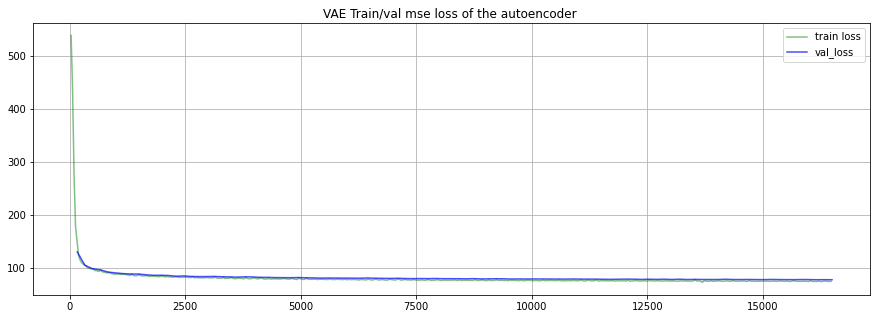

In [135]:
plt.figure(figsize = (15,5))
plt.plot(train_vae_steps, train_vae_losses, alpha=0.5, color = "green")
plt.plot(val_vae_steps, val_vae_losses, alpha=0.7, color = "blue")
plt.grid()
plt.legend(["train loss", "val_loss"])
plt.title("VAE Train/val mse loss of the autoencoder ")
plt.show()

In [128]:
val_best_index = np.argmin(val_vae_losses)
val_best_loss = np.min(val_vae_losses)

print(f"the best mse VAL   loss = {val_best_loss}, global step = {val_vae_steps[val_best_index]}")
print(f"the CURRENT mse VAL loss = {val_vae_losses[-1]}")
print()

train_best_index = np.argmin(train_vae_losses)
train_best_loss = np.min(train_vae_losses)

print(f"the BEST mse TRAIN loss = {train_best_loss}, global step = {train_vae_steps[train_best_index]}")
print(f"the CURRENT mse TRAIN loss = {train_vae_losses[-1]}")

the best mse VAL   loss = 78.33136304219563, global step = 16500
the CURRENT mse VAL loss = 78.33136304219563

the BEST mse TRAIN loss = 73.2317886352539, global step = 13696
the CURRENT mse TRAIN loss = 75.17183065414429


Original images:


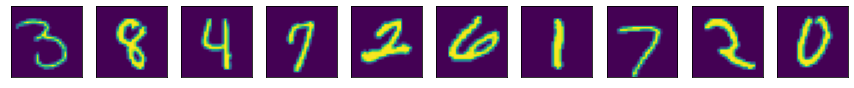

Decoded images Variational AE:


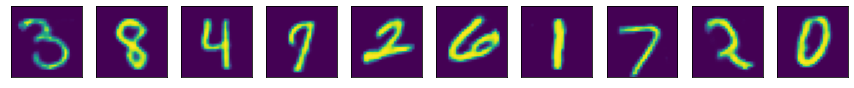

In [129]:
print("Original images:")
list_orig_images = [image[0].reshape(width_image, height_image) for i, image in enumerate(val_batch[0]) if i<20]
visualize_images(list_images=list_orig_images)

print("Decoded images Variational AE:")
vae_model.cpu()
list_decoded_images = [image.detach().numpy() for i, image in enumerate(vae_model(val_batch[0])[0]) if i<20]
visualize_images(list_images=list_decoded_images)

# print("Decoded images Simple AE:")
# ae_model.cpu()
# list_decoded_images = [image.detach().numpy() for i, image in enumerate(ae_model(val_batch[0])[0]) if i<20]
# visualize_images(list_images=list_decoded_images)

Original images:


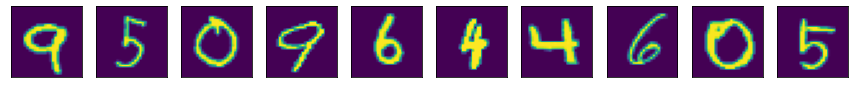

Decoded images Variational AE:


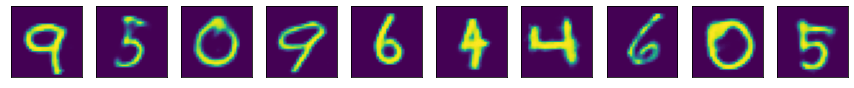

In [130]:
print("Original images:")
list_orig_images = [image[0].reshape(width_image, height_image) for i, image in enumerate(worst_val_batch[0]) if i<20]
visualize_images(list_images=list_orig_images)

print("Decoded images Variational AE:")
vae_model.cpu()
list_decoded_images = [image.detach().numpy() for i, image in enumerate(vae_model(worst_val_batch[0])[0]) if i<20]
visualize_images(list_images=list_decoded_images)

In [131]:
code_of_train_class = None
vae_model.cuda()
vae_model.encoder.eval()
for train_batch in tqdm(train_class_dataloader):
  images = train_batch[0].to(device)
  with torch.no_grad():
    
    code = vae_model.encoder(images)
    if code_of_train_class is None:
      code_of_train_class = code[0].cpu().detach().numpy()
    else:
      code_of_train_class = np.vstack([code_of_train_class, code[0].cpu().detach().numpy()])

100%|██████████| 165/165 [00:02<00:00, 59.58it/s]


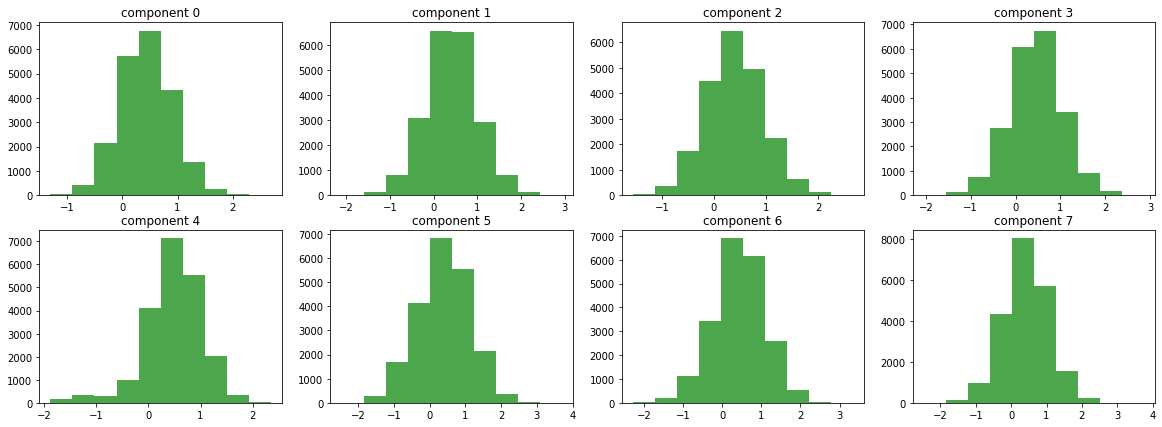

In [132]:
fig, axs = plt.subplots(2, 4)
fig.set_figheight(7)
fig.set_figwidth(20)
for i in range(8):
  row = i // 4
  col = i % 4
  axs[row,col].hist(code_of_train_class[:,i], color='green', alpha = 0.7)
  axs[row,col].set_title(f"component {i}")
plt.show()

In [133]:
# по первым элементам, видим, что распределение стало похоже на нормальное распределение с матожиданием = 0, отклонением = 1

In [136]:
# обучим классификатор

vae_encoder = VEncoder(encoder_size=ENCODER_SIZE, input_size=width_image*height_image)
vae_encoder.load_and_freeze(f"{PATH_MODELS}/vae_encoder.bin", device = device)

class_vae_model = SimpleClassificator(encoder = vae_encoder, out_size=OUT_SIZE)
if "cuda" in device.type: class_vae_model.cuda()

train_vae_info =  train_class_model(classificator = class_vae_model,
                                    num_epochs=50, 
                                    device = device,
                                    lr = 5e-4,
                                    train_dataloader = train_class_dataloader, 
                                    val_dataloader = val_class_dataloader, 
                                    print_losses=True)

epoch number = 0
val loss: 2.011328445540534, global step = 165, num_rep= 0
epoch number = 1
val loss: 1.444587293598387, global step = 330, num_rep= 1
epoch number = 2
val loss: 1.0303589800993602, global step = 495, num_rep= 2
epoch number = 3
val loss: 0.8270521875884798, global step = 660, num_rep= 3
epoch number = 4
val loss: 0.7319135798348321, global step = 825, num_rep= 4
epoch number = 5
val loss: 0.6657974537875917, global step = 990, num_rep= 5
epoch number = 6
val loss: 0.6356561349497901, global step = 1155, num_rep= 6
epoch number = 7
val loss: 0.6078793572054969, global step = 1320, num_rep= 7
epoch number = 8
val loss: 0.5968244820833206, global step = 1485, num_rep= 8
epoch number = 9
val loss: 0.5885527067714267, global step = 1650, num_rep= 9
epoch number = 10
val loss: 0.5796423281232516, global step = 1815, num_rep= 10
epoch number = 11
val loss: 0.5643544660674201, global step = 1980, num_rep= 11
epoch number = 12
val loss: 0.5671105533838272, global step = 2145, 

In [137]:
# отчет точность классификации
print(classification_report(y_pred= train_vae_info["val_preds"], y_true = train_vae_info["val_labels"]))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       894
           1       0.92      0.92      0.92       973
           2       0.83      0.85      0.84       881
           3       0.84      0.77      0.80       920
           4       0.85      0.83      0.84       920
           5       0.83      0.80      0.82       847
           6       0.90      0.90      0.90       950
           7       0.87      0.88      0.87       894
           8       0.80      0.84      0.82       835
           9       0.78      0.79      0.78       886

    accuracy                           0.85      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.85      0.85      0.85      9000



In [ ]:
# Вывод:  использование вариационного автоэнкодера понизило точность на 5 пунктов.

## Дополнительные идеи

In [140]:
# 1) Реализация классификатора на базе CNN. Использование связки CNN автоэнкодер + CNN классификатор.  
# CNN классификатор сможет лучше интрерпретировать признаки, выявленные CNN автоэнкодером.

# 2) Реализация вариационного автоэнкодера на базе CNN. 
# Такая реализация может помочь выявить геометрические признаки, которые лучше описывают множество MNIST.

# 3) Аугментация данных: добавить шум, повороты, смещения. Обучить классификатор на аугментированных данных.

# 4) Удаление из данных для обучения цифр, написание которых не позволяет сделать вывод о значении.
